# SISTER Production Summary

In [11]:
import json
import os
import pandas as pd
import IPython
import datetime as dt 
import re
import numpy as np
import warnings
import matplotlib.pyplot as plt
import statsmodels.api as sm
warnings.filterwarnings("ignore")

from maap.maap import MAAP
maap = MAAP(maap_host="sister-api.imgspec.org")

### Get list of jobs

_Rerun to retreive up-to-date job list_

In [12]:
job_list = maap.listJobs('anonymous').text
jobs  = json.loads(job_list)

### Set regex pattern to match tags

In [13]:
crid= "003"
pattern = f"^SISTER.*{crid}$"
start = dt.datetime(2023, 7, 25, 0, 0)

### Cycle through jobs and store job information for tags matching regex pattern
_If duplicate tags exists only most recently run job is retained_

TODO: Retain all jobs, index by job ID instead of tag

In [14]:
production = {}

for job in jobs['jobs']:
    job_id = list(job.keys())[0]
    tag = job[job_id]['tags'][0]
    tag = tag.upper()

    if re.match(pattern,tag):

        job_info = {}
        job_info['status'] = job[job_id]['status'].replace('job-','')
        
        if 'CWL' in tag:
            sister,sensor,product,datetime,crid = tag.split('_')
            job_info['PGE'] = product
        else:
            sister,sensor,level,product,datetime,crid = tag.split('_')
            job_info['PGE'] = f'{level}_{product}'

        job_info['sensor'] = sensor

        if 'time_start' in job[job_id]['job']['job_info'].keys():
            start_time = job[job_id]['job']['job_info']['time_start']
        else:
            start_time = '2000-01-01T00:00:00.0Z'
        job_info['start_time'] =dt.datetime.strptime(start_time,'%Y-%m-%dT%H:%M:%S.%fZ')

        if 'time_end' in job[job_id]['job']['job_info'].keys():
            end_time = job[job_id]['job']['job_info']['time_end']
        else:
            end_time = '2000-01-01T00:00:00.0Z'
        job_info['end_time'] =dt.datetime.strptime(end_time,'%Y-%m-%dT%H:%M:%S.%fZ')
        
        if 'time_queued' in job[job_id]['job']['job_info'].keys():
            queue_time = job[job_id]['job']['job_info']['time_queued']
        else:
            queue_time = '2000-01-01T00:00:00.0Z'  
        job_info['queue_time'] =dt.datetime.strptime(queue_time,'%Y-%m-%dT%H:%M:%S.%fZ')

        if 'duration' in job[job_id]['job']['job_info'].keys():
            job_duration = float(job[job_id]['job']['job_info']['duration'])/60
        else:
            job_duration = -1

        job_info['duration'] =job_duration

        instance_type = np.nan
        cores = np.nan
        memory = np.nan

        if 'facts' in job[job_id]['job']['job_info'].keys():
            if 'ec2_instance_type' in job[job_id]['job']['job_info']['facts'].keys():
                instance_type = job[job_id]['job']['job_info']['facts']['ec2_instance_type']

            if 'processorcount' in job[job_id]['job']['job_info']['facts'].keys():
                cores = job[job_id]['job']['job_info']['facts']['processorcount']

            if 'processorcount' in job[job_id]['job']['job_info']['facts'].keys():
                memorysize = float(job[job_id]['job']['job_info']['facts']['memorysize'].split()[0])
                memoryfree = float(job[job_id]['job']['job_info']['facts']['memoryfree'].split()[0])
                memory = memorysize - memoryfree

        job_info['instance_type'] = instance_type
        job_info['cores'] = cores
        job_info['memory'] = memory
        
        output_datasets = []
        input_datasets = []
        inputs_disk_usage = 0
        staged_disk_usage = 0

        if job_info['status'] == 'completed':
            if 'metrics' in job[job_id]['job']['job_info'].keys():
                for staged in job[job_id]['job']['job_info']['metrics']['products_staged']:
                    if staged['dataset_type'].startswith('L'):
                        staged_disk_usage+=staged['disk_usage']/1E9
                        for url in staged['urls']:
                            if url.startswith('http'):
                                output_datasets.append(url)

            for input_dataset in job[job_id]['job']['job_info']['metrics']['inputs_localized']:
                inputs_disk_usage += input_dataset['disk_usage']/1E9
                input_datasets.append(input_dataset['url'])


        job_info['output_datasets'] = output_datasets
        job_info['input_datasets'] = input_datasets
        job_info['inputs_disk_usage'] = inputs_disk_usage
        job_info['staged_disk_usage'] = staged_disk_usage
        job_info['tag'] = tag

        
        if job_info['queue_time'] < start:
            continue
        if (tag not in production.keys()) | (job_info['status'] == 'completed'):
            production[tag] = job_info
        elif job_info['start_time'] > production[tag]['start_time']:
            production[tag] = job_info


## Create production results dataframe
---

In [40]:
production_df = pd.DataFrame.from_records([production[tag] for tag in production.keys()])
production_df.index = list(production.keys())
production_df['core_hours'] = production_df['cores']*(production_df['duration']/60)
    
prod_complete = pd.DataFrame(columns = production_df.columns)

for tag,group in  production_df[production_df.status != 'failed'].groupby(by ='tag'):
    index =np.argmax(group.end_time)
    group.iloc[index].name
    prod_complete.loc[group.iloc[index].tag,:] = group.iloc[index]
    
metrics = ['duration','inputs_disk_usage','staged_disk_usage','cores']   
prod_complete.index.name = 'tag'
prod_complete[['sensor','PGE']+metrics+['instance_type']].to_csv("./sister_production_run_4_metrics.csv")    

## Get job statistics by sensor and PGE

In [41]:
production_mean = prod_complete.groupby(['sensor','PGE']).mean()[metrics]
production_mode = prod_complete.groupby(['sensor','PGE']).agg( lambda x: pd.Series.mode(x)[0])['instance_type']
production_count = prod_complete.groupby(['sensor','PGE']).count()
production_mean

duration  inputs_disk_usage  staged_disk_usage  \
sensor PGE                                                                
AVCL   CWL             177.120857           0.000000           0.000000   
       L1B_RDN          11.586172           3.146917           3.490453   
       L2A_CORFL         5.627685           3.255151           3.108151   
       L2A_RFL         107.538042           3.490453           6.593601   
       L2A_RSRFL         5.812215           6.593601           6.211150   
       L2B_AQUAPIG      20.064362           3.278014           0.002741   
       L2B_BENTHCOVER    1.873120           0.066404           0.000525   
       L2B_BENTHRFL     57.087920           0.564038           0.069060   
       L2B_FRCOV        18.735415           3.108151           0.035407   
       L2B_GRAINSIZE     1.339031           2.700445           0.000551   
       L2B_VEGBIOCHEM    2.318472           3.143558           0.039851   
AVNG   CWL             140.235224           0.000000           0.000000   
       L1B_RDN          21.353692           8.175282           0.273060   
       L2A_CORFL         0.819504           0.143895           0.130322   
       L2A_RFL          18.347065           0.277688           0.524299   
       L2A_RSRFL         0.615911           0.524299           0.260360   
       L2B_AQUAPIG       3.627329           0.152304           0.000578   
       L2B_FRCOV         7.689988           0.130322           0.001990   
       L2B_GRAINSIZE     0.990738           0.018734           0.000089   
       L2B_VEGBIOCHEM    0.724660           0.149786           0.003491   
DESIS  CWL              60.817239           0.000000           0.000000   
       L1B_RDN           1.710126           0.584707           2.127644   
       L2A_CORFL         0.515743           0.604545           0.518487   
       L2A_RFL          16.364961           2.127644           4.029369   
       L2A_RSRFL         1.689780           4.029369           1.034788   
       L2B_AQUAPIG      13.245808           0.543793           0.002613   
       L2B_BENTHCOVER    1.893501           0.212833           0.000679   
       L2B_BENTHRFL     38.202987           0.528344           0.221344   
       L2B_FRCOV         8.039500           0.518487           0.017536   
       L2B_VEGBIOCHEM    0.590434           0.536023           0.006769   
EMIT   CWL              94.343040           0.000000           0.000000   
       L1B_RDN           9.272273           2.079373           5.118948   
       L2A_CORFL         2.874646           3.801775           3.613559   
       L2A_RFL          75.241591           5.118948           9.754802   
       L2A_RSRFL         7.670857           9.754802           7.222984   
       L2B_AQUAPIG      18.573311           3.710280           0.006143   
       L2B_BENTHCOVER    2.006535           0.449754           0.002410   
       L2B_BENTHRFL    110.240226           3.817128           0.467716   
       L2B_FRCOV        15.083439           3.613559           0.027755   
       L2B_GRAINSIZE     1.231149           3.102579           0.000381   
       L2B_VEGBIOCHEM    2.609413           3.641314           0.038985   
PRISMA CWL              84.042243           0.000000           0.000000   
       L1B_RDN           8.185182           0.818257           1.406939   
       L2A_CORFL         0.998625           1.279737           1.221886   
       L2A_RFL          16.619317           1.406939           2.661511   
       L2A_RSRFL         1.706733           2.661511           2.441755   
       L2B_AQUAPIG      10.755073           1.243935           0.004297   
       L2B_FRCOV        10.739287           1.221886           0.010834   
       L2B_GRAINSIZE     1.079682           1.258455           0.001912   
       L2B_VEGBIOCHEM    0.986290           1.232720           0.009120   

                           cores  
sensor PGE                        
AVCL   CWL              2.416667  
       L1B_RDN     

## Print CSV

In [84]:
PGEs = {'CWL':'CWL Workflow',
         'L1B_RDN':'L1 Preprocess',
         'L2A_RFL':'L2 ISOFIT',
         'L2A_RSRFL' :'L2 Resample',
         'L2A_CORFL':'L2 Correction',
         'L2B_FRCOV':'L2 Fractional Cover',
         'L2B_GRAINSIZE':'L2 Snow grain size',
         'L2B_BENTHRFL':'L2 Benth Rfl',
         'L2B_AQUAPIG':'L2 Aquatic Pigments',
         'L2B_BENTHCOVER':'L2 Benth Cover',
         'L2B_VEGBIOCHEM':'L2 Vegetation Traits'}

sensors = {'AVCL': 'AVIRIS-CL',
           'AVNG': 'AVIRIS-NG',
           'PRISMA':'PRISMA',
           'DESIS':'DESIS',
           'EMIT':'EMIT'}

for pge in PGEs.keys():
    for sensor in sensors.keys():
        if pge in production_mean.loc[(sensor)].index:
            row = production_mean.loc[(sensor,pge)].values.round(3).astype(str).tolist()
            instance_type = production_mode.loc[(sensor,pge)]
            count  = str(production_count.loc[(sensor,pge),'tag'])
        else:
            continue
            count = '0'
            instance_type = 'NA'
            row = ['0', '0', '0', '0']
        print(','.join([f'{PGEs[pge]} - {sensors[sensor]}'] + row + [instance_type,count]))


CWL Workflow - AVIRIS-CL,177.121,0.0,0.0,2.417,t3.medium,24
CWL Workflow - AVIRIS-NG,140.235,0.0,0.0,2.067,t3.medium,60
CWL Workflow - PRISMA,84.042,0.0,0.0,2.24,t3.medium,25
CWL Workflow - DESIS,60.817,0.0,0.0,2.4,t3.medium,5
CWL Workflow - EMIT,94.343,0.0,0.0,3.067,r5.xlarge,15
L1 Preprocess - AVIRIS-CL,11.586,3.147,3.49,36.0,c4.8xlarge,24
L1 Preprocess - AVIRIS-NG,21.354,8.175,0.273,3.1,r5.large,60
L1 Preprocess - PRISMA,8.185,0.818,1.407,2.96,r5.large,25
L1 Preprocess - DESIS,1.71,0.585,2.128,2.0,r5.large,5
L1 Preprocess - EMIT,9.272,2.079,5.119,36.0,c4.8xlarge,15
L2 ISOFIT - AVIRIS-CL,107.538,3.49,6.594,36.0,c4.8xlarge,24
L2 ISOFIT - AVIRIS-NG,18.347,0.278,0.524,36.0,c4.8xlarge,59
L2 ISOFIT - PRISMA,16.619,1.407,2.662,36.0,c4.8xlarge,25
L2 ISOFIT - DESIS,16.365,2.128,4.029,36.0,c4.8xlarge,5
L2 ISOFIT - EMIT,75.242,5.119,9.755,36.0,c5.9xlarge,15
L2 Resample - AVIRIS-CL,5.812,6.594,6.211,2.5,r5.large,24
L2 Resample - AVIRIS-NG,0.616,0.524,0.26,2.61,r5.large,59
L2 Resample - PRISMA,1

# Deliverable counts

In [66]:
scene_df = pd.read_csv('./sister_production_4_list.csv', encoding='utf-8-sig')
# Strip unicode character
scene_df.l1_granule = scene_df.l1_granule.map(lambda x: x.replace('\ufeff',''))
scene_df = scene_df[scene_df.Priority != 'REMOVE']
scene_df.groupby(by='Instrument').count()['Platform']

Instrument
AVIRIS Classic    24
AVIRIS-NG         60
DESIS              5
EMIT              15
PRISMA            25
Name: Platform, dtype: int64

In [67]:
deliverables = [
         'L2A_RSRFL',
         'L2A_CORFL',
         'L2B_FRCOV',
         'L2B_GRAINSIZE',
         'L2B_VEGBIOCHEM',         
         'L2B_BENTHRFL',
         'L2B_AQUAPIG',
         'L2B_BENTHCOVER',
         'L2B_VEGBIOCHEM']

deliver_df = prod_complete[[x in deliverables for x in prod_complete.PGE]]
deliver_count = deliver_df.groupby(['sensor','PGE']).count()
deliver_count[['tag']]


tag
sensor PGE                
AVCL   L2A_CORFL        24
       L2A_RSRFL        24
       L2B_AQUAPIG      23
       L2B_BENTHCOVER    3
       L2B_BENTHRFL      3
       L2B_FRCOV        24
       L2B_GRAINSIZE    15
       L2B_VEGBIOCHEM   24
AVNG   L2A_CORFL        59
       L2A_RSRFL        59
       L2B_AQUAPIG      50
       L2B_FRCOV        59
       L2B_GRAINSIZE     4
       L2B_VEGBIOCHEM   51
DESIS  L2A_CORFL         5
       L2A_RSRFL         5
       L2B_AQUAPIG       3
       L2B_BENTHCOVER    1
       L2B_BENTHRFL      1
       L2B_FRCOV         5
       L2B_VEGBIOCHEM    5
EMIT   L2A_CORFL        15
       L2A_RSRFL        15
       L2B_AQUAPIG      13
       L2B_BENTHCOVER    4
       L2B_BENTHRFL      4
       L2B_FRCOV        15
       L2B_GRAINSIZE     2
       L2B_VEGBIOCHEM   15
PRISMA L2A_CORFL        25
       L2A_RSRFL        25
       L2B_AQUAPIG      19
       L2B_FRCOV        25
       L2B_GRAINSIZE     6
       L2B_VEGBIOCHEM   25

In [85]:
print(f"Total production data volume: {prod_complete['staged_disk_usage'].sum()} Gb")
print(f"Total delivery data volume: {deliver_count['staged_disk_usage'].sum()} Gb")

Total production data volume: 1159.872549058001 Gb
Total delivery data volume: 655 Gb


### Product counts

In [86]:
product_PGEs = {
         'L1B_RDN':'L1 Preprocess',
         'L2A_RFL':'L2 ISOFIT',
         'L2A_RSRFL' :'L2 Resample',
         'L2A_CORFL':'L2 Correction',
         'L2B_FRCOV':'L2 Fractional Cover',
         'L2B_GRAINSIZE':'L2 Snow grain size',
         'L2B_VEGBIOCHEM':'L2 Vegetation Traits',
         'L2B_BENTHRFL':'L2 Benth Rfl',
         'L2B_AQUAPIG':'L2 Aquatic Pigments',
         'L2B_BENTHCOVER':'L2 Benth Cover'}

volume_stats = prod_complete.groupby(by = ['sensor','PGE']).agg({'tag':['count']})

for sensor in sensors.keys():

    stats = []

    for pge in product_PGEs.keys():
        if pge in volume_stats.loc[sensor].index: 
            pge_stats= volume_stats.loc[sensor].loc[pge].astype(float)

            stats+=pge_stats.values.astype(int).tolist()

    print(sensor + "," + ','.join([str(x) for x in stats]))

AVCL,24,24,24,24,24,15,24,3,23,3
AVNG,60,59,59,59,59,4,51,50
PRISMA,25,25,25,25,25,6,25,19
DESIS,5,5,5,5,5,5,1,3,1
EMIT,15,15,15,15,15,2,15,4,13,4


### Production data volume

In [87]:
product_PGEs = {
         'L1B_RDN':'L1 Preprocess',
         'L2A_RFL':'L2 ISOFIT',
         'L2A_RSRFL' :'L2 Resample',
         'L2A_CORFL':'L2 Correction',
         'L2B_FRCOV':'L2 Fractional Cover',
         'L2B_GRAINSIZE':'L2 Snow grain size',
         'L2B_VEGBIOCHEM':'L2 Vegetation Traits',
         'L2B_BENTHRFL':'L2 Benth Rfl',
         'L2B_AQUAPIG':'L2 Aquatic Pigments',
         'L2B_BENTHCOVER':'L2 Benth Cover'}

volume_stats = prod_complete.groupby(by = ['sensor','PGE']).agg({'staged_disk_usage':['sum','mean']})

for sensor in sensors.keys():

    stats = []

    for pge in product_PGEs.keys():
        if pge in volume_stats.loc[sensor].index: 
            pge_stats= volume_stats.loc[sensor].loc[pge].astype(float)

            stats+=pge_stats.round(2).values.tolist()
            stats.append(" ")

    print(sensor + "," + ','.join([str(x) for x in stats]))

AVCL,83.77,3.49, ,158.25,6.59, ,149.07,6.21, ,74.6,3.11, ,0.85,0.04, ,0.01,0.0, ,0.96,0.04, ,0.21,0.07, ,0.06,0.0, ,0.0,0.0, 
AVNG,16.38,0.27, ,30.93,0.52, ,15.36,0.26, ,7.69,0.13, ,0.12,0.0, ,0.0,0.0, ,0.18,0.0, ,0.03,0.0, 
PRISMA,35.17,1.41, ,66.54,2.66, ,61.04,2.44, ,30.55,1.22, ,0.27,0.01, ,0.01,0.0, ,0.23,0.01, ,0.08,0.0, 
DESIS,10.64,2.13, ,20.15,4.03, ,5.17,1.03, ,2.59,0.52, ,0.09,0.02, ,0.03,0.01, ,0.22,0.22, ,0.01,0.0, ,0.0,0.0, 
EMIT,76.78,5.12, ,146.32,9.75, ,108.34,7.22, ,54.2,3.61, ,0.42,0.03, ,0.0,0.0, ,0.58,0.04, ,1.87,0.47, ,0.08,0.01, ,0.01,0.0, 


### Job duration table

In [88]:
product_PGEs = {
         'L1B_RDN':'L1B Preprocess',
         'L2A_RFL':'L2A ISOFIT',
         'L2A_RSRFL' :'L2A Resample',
         'L2A_CORFL':'L2A Correction',
         'L2B_FRCOV':'L2B Fractional Cover',
         'L2B_GRAINSIZE':'L2B Snow grain size',
         'L2B_VEGBIOCHEM':'L2B Vegetation Traits',
         'L2B_BENTHRFL':'L2 Benth Rfl',
         'L2B_AQUAPIG':'L2 Aquatic Pigments',
         'L2B_BENTHCOVER':'L2 Benth Cover',
         'CWL':'CWL Workflow',}

duration_stats = prod_complete.groupby(by = ['sensor','PGE']).agg({'duration':['min','mean','max']})

for sensor in sensors.keys():

    stats = []

    for pge in product_PGEs.keys():
        if pge in duration_stats.loc[sensor].index: 
            pge_stats= duration_stats.loc[sensor].loc[pge]

            stats+=pge_stats.round(1).values.tolist()
            stats.append(" ")
        else:
            stats+=['0','0','0'," "]

    print(sensor + "," + ','.join([str(x) for x in stats]))

AVCL,2.4,11.6,25.8, ,15.7,107.5,222.4, ,1.2,5.8,15.0, ,1.1,5.6,15.0, ,5.9,18.7,35.2, ,0.7,1.3,2.5, ,0.6,2.3,4.7, ,6.8,57.1,89.1, ,5.5,20.1,47.6, ,1.8,1.9,2.0, ,5.0,177.1,307.1, 
AVNG,-1.0,21.4,111.3, ,4.3,18.3,48.4, ,0.1,0.6,2.1, ,0.2,0.8,2.5, ,4.5,7.7,15.2, ,0.9,1.0,1.2, ,0.3,0.7,2.4, ,0,0,0, ,0.8,3.6,9.5, ,0,0,0, ,-1.0,140.2,239.3, 
PRISMA,5.9,8.2,11.1, ,12.8,16.6,23.8, ,1.4,1.7,2.5, ,0.8,1.0,1.8, ,5.6,10.7,19.7, ,0.5,1.1,2.2, ,0.7,1.0,2.6, ,0,0,0, ,7.6,10.8,14.2, ,0,0,0, ,18.5,84.0,196.2, 
DESIS,1.2,1.7,2.4, ,12.6,16.4,22.4, ,1.5,1.7,2.2, ,0.5,0.5,0.5, ,7.1,8.0,8.7, ,0,0,0, ,0.5,0.6,0.7, ,38.2,38.2,38.2, ,9.7,13.2,15.8, ,1.9,1.9,1.9, ,17.8,60.8,86.2, 
EMIT,4.6,9.3,20.5, ,48.7,75.2,125.4, ,5.5,7.7,13.6, ,1.8,2.9,4.0, ,11.1,15.1,23.0, ,0.9,1.2,1.6, ,1.2,2.6,3.9, ,39.2,110.2,198.1, ,9.4,18.6,38.9, ,2.0,2.0,2.1, ,6.1,94.3,272.7, 


L2A ISOFIT,7.794,11.23
L2 Aquatic Pigments,0.177,0.178
L2 Benth Cover,0.013,0.061
L2 Benth Rfl,0.701,1.364
L2B Fractional Cover,0.075,0.338
L2B Snow grain size,0.004,0.05
L2 Vegetation Traits,0.02,0.027


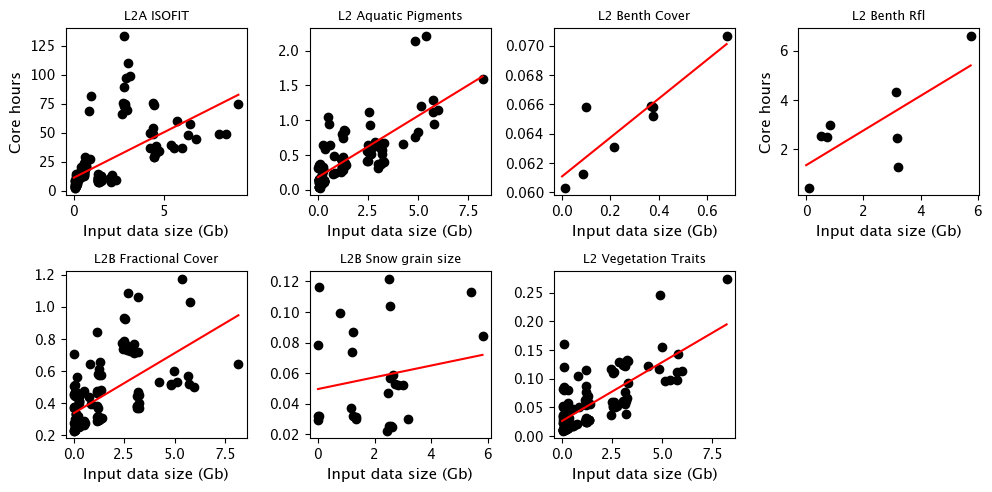

In [89]:
PGEs = {'L2A_RFL':'L2A ISOFIT',
         'L2B_FRCOV':'L2B Fractional Cover',
         'L2B_GRAINSIZE':'L2B Snow grain size',
         'L2B_VEGBIOCHEM':'L2B Vegetation Traits',
         'L2B_BENTHRFL':'L2 Benth Rfl',
         'L2B_AQUAPIG':'L2 Aquatic Pigments',
         'L2B_BENTHCOVER':'L2 Benth Cover',
         'L2B_VEGBIOCHEM':'L2 Vegetation Traits'}

fig = plt.figure(figsize = (10,5))
a = 1
for p,pge in prod_complete.groupby(by = 'PGE'):
    if p in PGEs.keys():

        x =pge['inputs_disk_usage'].values.astype(float)
        y =pge['core_hours'].values.astype(float)

        predict_x =np.linspace(0,x.max())

        model = sm.OLS(y,sm.add_constant(x)).fit()
        b0,b1 = model.params
        print(','.join([PGEs[p],str(round(b1,3)),str(round(b0,3))]))
                
        predict_y = model.predict(sm.add_constant(predict_x))

        equation = f'y = {b1}x + {b0}'

        ax = fig.add_subplot(2,4,a)
        ax.set_title(PGEs[p],fontsize = 9)

        ax.scatter(x,y,c = 'k')
        ax.plot(predict_x,predict_y,c = 'r')
        if a in [1,4]:
            ax.set_ylabel('Core hours',fontsize = 11)
        ax.set_xlabel('Input data size (Gb)',fontsize = 11)
        a+=1
        
fig.tight_layout(pad=1.0)    

plt.savefig(f'./input_v_core_hours.png',
            dpi = 300, bbox_inches= 'tight')


L2A ISOFIT,1.898,-0.005
L2 Aquatic Pigments,0.001,0.001
L2 Benth Cover,0.008,-0.001
L2 Benth Rfl,0.113,0.04
L2B Fractional Cover,0.009,0.002
L2B Snow grain size,-0.0,0.001
L2 Vegetation Traits,0.011,0.001


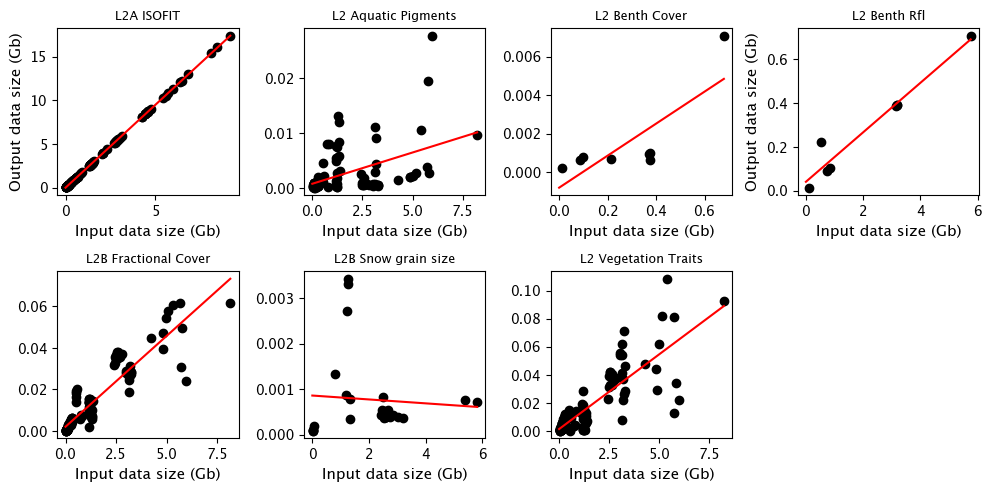

In [90]:
PGEs = {'L2A_RFL':'L2A ISOFIT',
         'L2B_FRCOV':'L2B Fractional Cover',
         'L2B_GRAINSIZE':'L2B Snow grain size',
         'L2B_VEGBIOCHEM':'L2B Vegetation Traits',         
         'L2B_BENTHRFL':'L2 Benth Rfl',
         'L2B_AQUAPIG':'L2 Aquatic Pigments',
         'L2B_BENTHCOVER':'L2 Benth Cover',
         'L2B_VEGBIOCHEM':'L2 Vegetation Traits'}

fig = plt.figure(figsize = (10,5))
a = 1
    
for p,pge in prod_complete.groupby(by = 'PGE'):
    if p in PGEs.keys():

        x =pge['inputs_disk_usage'].values.astype(float)
        y =pge['staged_disk_usage'].values.astype(float)

        predict_x =np.linspace(0,x.max())

        model = sm.OLS(y,sm.add_constant(x)).fit()
        b0,b1 = model.params
        print(','.join([PGEs[p],str(round(b1,3)),str(round(b0,3))]))
                
        predict_y = model.predict(sm.add_constant(predict_x))

        equation = f'y = {b1}x + {b0}'

        ax = fig.add_subplot(2,4,a)
        ax.set_title(PGEs[p],fontsize = 9)

        ax.scatter(x,y,c = 'k')
        ax.plot(predict_x,predict_y,c = 'r')
        if a in [1,4]:
            ax.set_ylabel('Output data size (Gb)',fontsize = 11)
        ax.set_xlabel('Input data size (Gb)',fontsize = 11)
        a+=1
        
fig.tight_layout(pad=1.0)    

plt.savefig(f'./input_v_output_data.png',
            dpi = 300, bbox_inches= 'tight')
    
    